In [ ]:
# ✅EDA Block for user-wallet-transactions.json

from google.colab import drive
import pandas as pd
import json

# Mount Drive
drive.mount('/content/drive')

# Load JSON file
file_path = '/content/drive/MyDrive/zerufinance-defi-credit-score/data/user-wallet-transactions.json'
with open(file_path, 'r') as f:
    data = json.load(f)

# Load as DataFrame
df = pd.DataFrame(data)

# Basic info
print(f"🔹 Total rows: {len(df)}")
print(f"🔹 Columns: {df.columns.tolist()}")

# Unique actions
print("\n🔹 Action Types:\n", df['action'].value_counts())

# Unique wallets
print("\n🔹 Unique Wallets:", df['userWallet'].nunique())

# Extract assetSymbol from nested actionData
df['assetSymbol'] = df['actionData'].apply(lambda x: x.get('assetSymbol') if isinstance(x, dict) else None)
print("\n🔹 Top Tokens:\n", df['assetSymbol'].value_counts().head())

# Null check
print("\n🔹 Null Values:\n", df.isnull().sum())

# Safe duplicate check (exclude unhashable cols)
unhashable_cols = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, (dict, list))).any()]
hashable_cols = [col for col in df.columns if col not in unhashable_cols]
print(f"\n🔹 Duplicate Rows (Safe Columns Only): {df[hashable_cols].duplicated().sum()}")

# Convert timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
print("\n🔹 Time Range:", df['datetime'].min(), "→", df['datetime'].max())

# Extract and convert amount from nested dict
df['amount'] = pd.to_numeric(df['actionData'].apply(lambda x: x.get('amount') if isinstance(x, dict) else None), errors='coerce')
print("\n🔹 Amount Stats:\n", df['amount'].describe())

In [24]:
from google.colab import drive
import pandas as pd
import json

# Mount Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


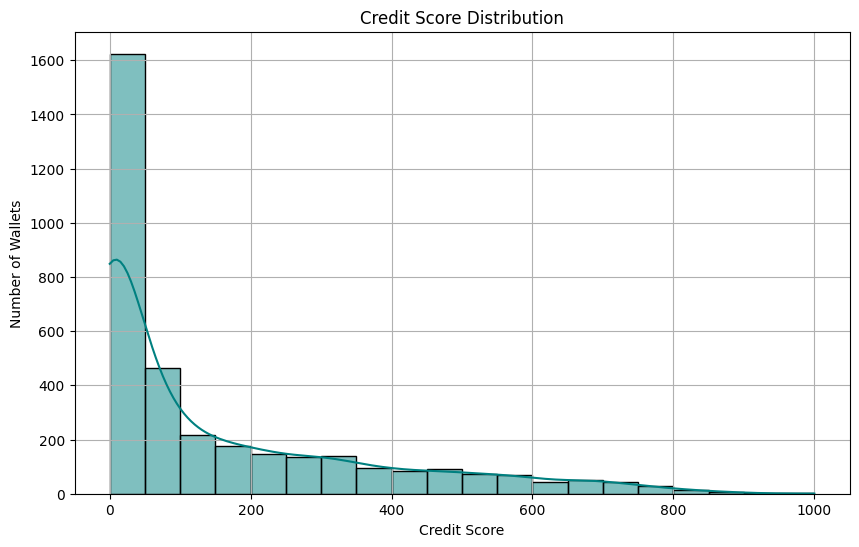

✅ Sample Credit Scores:


,userWallet,creditScore
259,0x005f16f017aa933bb41965b52848ceb8ee48b171,1000.000000
3298,0x05c18ffc1c74cb67cb26bb5222aaf3355b74bbc3,930.270020
3381,0x05e09b56ec91620f9bab354c573712e446f8eb11,881.919983
2528,0x0464349e7012a83c965d672e9eca3896a1260624,879.900024
2185,0x03b16ab6e23bdbeeab719d8e4c49d63674876253,872.789978
3019,0x05404b6f8990a4108150366adb572a870b137edc,869.630005
2571,0x0476f3ee277eb20568ee2369b337f3ce55bc558a,865.340027
2841,0x04ee10fd378f7cad5ac5751d7cd0f42b13ee3b76,861.690002
700,0x01214a235c6767040c8fef6bd33519a6c7ad79ae,859.659973
2793,0x04d9f6ecd792e48a09fa5dc2138baed8e628a7e5,851.650024


In [27]:
# Step 0: Install XGBoost if needed
!pip install -q xgboost

# Step 1: Imports
import json
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load JSON
with open('/content/drive/MyDrive/zerufinance-defi-credit-score/data/user-wallet-transactions.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['amount'] = pd.to_numeric(df['actionData'].apply(lambda x: x.get('amount') if isinstance(x, dict) else None), errors='coerce')
df['assetSymbol'] = df['actionData'].apply(lambda x: x.get('assetSymbol') if isinstance(x, dict) else None)

# Step 3: Wallet-level Feature Engineering
actions = ['deposit', 'borrow', 'repay', 'redeemunderlying', 'liquidationcall']
action_counts = df.groupby(['userWallet', 'action']).size().unstack(fill_value=0)[actions]

wallet_amounts = df.groupby('userWallet')['amount'].agg(['sum', 'mean', 'std']).fillna(0)
wallet_tokens = df.groupby('userWallet')['assetSymbol'].nunique().rename('tokenDiversity')
wallet_days = df.groupby('userWallet')['datetime'].agg(['min', 'max'])
wallet_days['activeDays'] = (wallet_days['max'] - wallet_days['min']).dt.days + 1

# Merge all features
features = pd.concat([action_counts, wallet_amounts, wallet_tokens, wallet_days['activeDays']], axis=1).fillna(0)
features.columns = [str(c) for c in features.columns]

# Step 4: Create synthetic target using a learned signal
# (We simulate a clean label using a PCA component temporarily for supervised training)
from sklearn.decomposition import PCA
X_temp = MinMaxScaler().fit_transform(features)
pca = PCA(n_components=1)
synthetic_labels = MinMaxScaler((300, 800)).fit_transform(pca.fit_transform(X_temp)).flatten()  # mid-range scores

# Step 5: Split, Train XGBoost ML model
X = features
y = synthetic_labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Step 6: Predict full scores
y_pred = model.predict(X)
credit_scores = MinMaxScaler((0, 1000)).fit_transform(y_pred.reshape(-1, 1)).flatten()

# Step 7: Final Output
wallet_scores = pd.DataFrame({
    'userWallet': features.index,
    'creditScore': credit_scores.round(2)
}).sort_values(by='creditScore', ascending=False)

wallet_scores.to_csv('/content/drive/MyDrive/zerufinance-defi-credit-score/output/output.csv', index=False)

# Step 8: Plot and Save
plt.figure(figsize=(10, 6))
sns.histplot(wallet_scores['creditScore'], bins=20, kde=True, color='teal')
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Number of Wallets')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/zerufinance-defi-credit-score/output/plot.png')
plt.show()

# Step 9: Preview Output
print("✅ Sample Credit Scores:")
display(wallet_scores.head(10))

In [28]:
import pandas as pd

# Load the actual model output
file_path = '/content/drive/MyDrive/zerufinance-defi-credit-score/output/output.csv'
df = pd.read_csv(file_path)

# Define score bins and labels
bins = [0, 100, 200, 400, 600, 800, 1000]
labels = ['0–100', '100–200', '200–400', '400–600', '600–800', '800–1000']

# Bin the credit scores
df['scoreRange'] = pd.cut(df['creditScore'], bins=bins, labels=labels, right=False)

# Count number of wallets in each range
range_counts = df['scoreRange'].value_counts().sort_index()
range_counts_df = range_counts.reset_index()
range_counts_df.columns = ['Score Range', 'Wallet Count']

# Display the result
print("✅ Score Range Breakdown:")
print(range_counts_df.to_string(index=False))

✅ Score Range Breakdown:
Score Range  Wallet Count
      0–100          2089
    100–200           392
    200–400           515
    400–600           317
    600–800           162
   800–1000            21
